### Basic Imports

In [1]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [2]:
QUBITS_NUM = 4 
N = 16
K = 4
NUM_SHOTS = 1024
NUM_ITERATIONS = 100

w_vector = np.asarray([4,3,2,1])

### Simulator Backend

In [3]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [4]:
from scipy.optimize import minimize

### K input states (computational basis)

In [5]:
from utiles import *

In [6]:
input_states = get_first_k_eigenvectors_from_n_computational_basis(K, N)

### Ansatz State

In [7]:
from ansatz_circuit_item2 import get_full_variational_quantum_circuit

In [8]:
init_circuit_params = {
    "thetas": np.random.uniform(low=0, high=2*np.pi, size=8),
    "phis": np.random.uniform(low=0, high=2*np.pi, size=4),
    "D1": 2,
    "D2": 8
}

In [9]:
def prepare_circuit_params(thetas) -> Dict:
     return {
    "thetas": thetas[4:],
    "phis": thetas[:4],
    "D1": 2,
    "D2": 8
     }

In [10]:
def get_ansatz_state(circuit_params, input_state):
    circuit_params_with_input_state = {**circuit_params, "input_state": input_state}
    return get_full_variational_quantum_circuit(**circuit_params_with_input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [11]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [12]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [13]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [14]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [15]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [16]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [17]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [18]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [19]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian):
    L_w = 0
    circuit_params = prepare_circuit_params(thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(LiH_molecule_4_qubits)
    
    for j in tqdm(range(K)):
        ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[j])
        approximated_energy = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        insert_approximated_energy_to_list_of_all_approximated_energies(
            approximated_energies_dict["approximated_eneriges_"+str(j)], approximated_energy)
        L_w += w_vector[j]*approximated_energy
        
    return L_w

### Optimization

In [20]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian):
    initial_thetas = np.random.uniform(low=0, high=360, size=12)
    optimizer_result = minimize(
                            cost_function,
                            x0=initial_thetas,
                            args=(hamiltonian),
                            method="COBYLA",
                            options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = prepare_circuit_params(optimizer_result.x)
    
    return optimal_thetas

In [21]:
def get_approximated_k_eigenvalues_of_hamiltonian(hamiltonian):
    approximated_k_eigenvalues = []
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    for eigenvalue_index, eigenvector in enumerate(computational_eigenvectors):
        optimal_ansatz_state = get_ansatz_state(optimal_thetas, eigenvector)
        approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)
        approximated_k_eigenvalues.append(approximated_eigenvalue)

    return approximated_k_eigenvalues

## Comparsion

In [22]:
from numpy import linalg as LA
from statistics import mean

def get_mean_approximation_error(exact_k_eigenvalues, approximated_k_eigenvalues):
    approximated_errors = []
    for exact_eigenvalue, approximated_eigenvalue in zip(exact_k_eigenvalues, approximated_k_eigenvalues):
        approximated_errors.append(abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue))
        
    return mean(approximated_errors)

In [23]:
def get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, k):
    eigenvalues = LA.eig(hamiltonian.to_matrix())[0]
    
    return sorted(eigenvalues)[:k]

In [24]:
def compare_exact_and_approximated_eigenvectors(hamiltonian, approximated_k_eigenvalues):
    exact_k_eigenvalues = get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, K)
    print("Exact K Eigenvalues:")
    print(exact_k_eigenvalues)
    
    print("\nApproximated K Eigenvalues:")
    print(sorted(approximated_k_eigenvalues))

    print("\nMean Approximation error:")
    print(get_mean_approximation_error(exact_k_eigenvalues, sorted(approximated_k_eigenvalues)))

## Visualization

In [25]:
approximated_energies_dict = { "approximated_eneriges_0": [],
"approximated_eneriges_1":[],
"approximated_eneriges_2": [],
"approximated_eneriges_3": []}

In [26]:
def initialize_approximated_energies_dict():
    return { "approximated_eneriges_0": [],
        "approximated_eneriges_1":[],
        "approximated_eneriges_2": [],
        "approximated_eneriges_3": []}

In [27]:
def insert_approximated_energy_to_list_of_all_approximated_energies(approximated_energies_list, energy):
    approximated_energies_list.append(energy)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_convergence_of_optimization_process(approximated_energies, hamiltonian, margin=0.02):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0,margin)
    base_colors_list = list(mcolors.BASE_COLORS.keys())
    
    exact_k_eigenvalues = get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, K)
    print(exact_k_eigenvalues)
    for energy_level, eigenvalue in enumerate(exact_k_eigenvalues):
        energy_level_name = "E_{0}".format(str(energy_level))
        
        plt.axhline(y = eigenvalue, 
                    color = base_colors_list[energy_level], 
                    linestyle = 'dotted', label=energy_level_name)
        plt.plot(approximated_energies["approximated_eneriges_{0}".format(str(energy_level))],
                 color = base_colors_list[energy_level], 
                 label="Weighted_SSVQE({0})".format(energy_level_name))
    
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [29]:
from qiskit.opflow import X, Z, Y, I, H, S

In [30]:
LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
-0.0029329964409502266*(X^X^Y^Y) + \
0.0029329964409502266*(X^Y^Y^X) + \
0.01291078027311749*(X^Z^X^I) + \
-0.0013743761078958677*(X^Z^X^Z) + \
0.011536413200774975*(X^I^X^I) + \
0.0029329964409502266*(Y^X^X^Y) + \
-0.0029329964409502266*(Y^Y^X^X) + \
0.01291078027311749*(Y^Z^Y^I) + \
-0.0013743761078958677*(Y^Z^Y^Z) + \
0.011536413200774975*(Y^I^Y^I) + \
0.16199475388004184*(Z^I^I^I) + \
0.011536413200774975*(Z^X^Z^X) + \
0.011536413200774975*(Z^Y^Z^Y) + \
0.12444770133137588*(Z^Z^I^I) + \
0.054130445793298836*(Z^I^Z^I) + \
0.05706344223424907*(Z^I^I^Z) + \
0.012910780273117487*(I^X^Z^X) + \
-0.0013743761078958677*(I^X^I^X) + \
0.012910780273117487*(I^Y^Z^Y) + \
-0.0013743761078958677*(I^Y^I^Y) + \
0.16199475388004186*(I^Z^I^I) + \
0.05706344223424907*(I^Z^Z^I) + \
0.054130445793298836*(I^Z^I^Z) + \
-0.013243698330265966*(I^I^Z^I) + \
0.08479609543670981*(I^I^Z^Z) + \
-0.013243698330265952*(I^I^I^Z)

In [31]:
%%time
LiH_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(LiH_molecule_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.92s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.29s/it]


CPU times: total: 16min 48s
Wall time: 17min 18s


In [32]:
compare_exact_and_approximated_eigenvectors(LiH_molecule_4_qubits, LiH_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j)]

Approximated K Eigenvalues:
[-7.6031612073357175, -7.514047133238333, -7.4966395931411425, -7.4626337834414525]

Mean Approximation error:
0.03426459475601994


In [33]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.4359978177503105, -7.3757160134880255, -7.478056967985576, -7.43423318511301, -7.355443130290436, -7.192724859258253, -7.450920788878105, -7.528286487074502, -7.394739360509528, -7.317749147572674, -7.286270047581571, -7.4539545298694785, -7.44412070623346, -7.402133541137446, -7.552664643558308, -7.568283862713287, -7.573591027000904, -7.535135660615394, -7.597412805282164, -7.538645554626885, -7.578921687444361, -7.586715825227806, -7.565345358431128, -7.423376452717088, -7.551201224131409, -7.539770740005005, -7.592254126623817, -7.539227622021473, -7.5750395368613095, -7.588661555901759, -7.564936011228601, -7.569946985202293, -7.597800786473079, -7.60174429655928, -7.607208125538174, -7.588006467364922, -7.603319168883829, -7.603252712613508, -7.610148493285537, -7.596728890615095, -7.611359454917831, -7.605137074986479, -7.5827355988868685, -7.607745782500884, -7.596119842956979, -7.605197446864565, -7.618699365136879, -7.581959892315226, -7.619830

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j)]


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


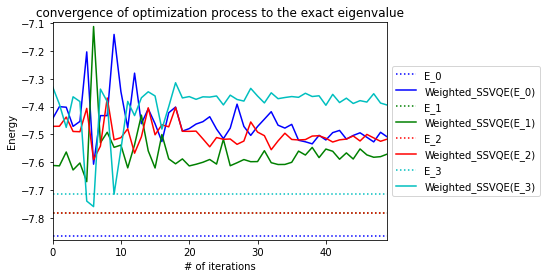

In [34]:
LiH_approximated_energies = {'approximated_eneriges_0': [-7.443763256904104, -7.4002130802981165, -7.402247491880844, -7.470848596022202, -7.45320004578142, -7.2037442823809394, -7.606622032604259, -7.432350599744895, -7.432495103535102, -7.141159809219269, -7.34603922757036, -7.476135398795488, -7.280043003574207, -7.4614181224914295, -7.407924717612185, -7.461586578652535, -7.525445976535891, -7.422114431402694, -7.401649526037618, -7.488021953946464, -7.47896570893905, -7.462685937161847, -7.454120832230556, -7.436292572707697, -7.480688115871342, -7.515063846777348, -7.477177021961932, -7.391244710949009, -7.471217858315684, -7.503242588552382, -7.471439257727218, -7.44505573833778, -7.418285185624123, -7.466695823049642, -7.4771052531993325, -7.4637738318283535, -7.520776558858023, -7.526230791574609, -7.533608947411593, -7.503004948009757, -7.519724331102011, -7.493384913528219, -7.485478644775202, -7.516510223399673, -7.503475090881356, -7.494010354458551, -7.510090310795372, -7.526632388070386, -7.492160858734219, -7.5090846022988345], 'approximated_eneriges_1': [-7.611160770738447, -7.612537039823402, -7.5628667736575075, -7.627321643310454, -7.602218901158253, -7.669321267055824, -7.112869137843162, -7.529831878035033, -7.492031424566759, -7.546144927687019, -7.5380518543846815, -7.619806507952486, -7.536960192278364, -7.430594135829916, -7.558781662996708, -7.620192075334588, -7.500080654402885, -7.5874392595184466, -7.60518715593763, -7.587653509223957, -7.612775269021471, -7.6068484660945295, -7.599678769877363, -7.589714279771383, -7.60619548365883, -7.51735676728312, -7.612125836144872, -7.6014638647121675, -7.5899647846917055, -7.5976032888517775, -7.597212073112908, -7.558188737021209, -7.601200874808052, -7.607713345897209, -7.607499093171809, -7.599792654361252, -7.5596730670773855, -7.573728870000363, -7.546383632358012, -7.583001966857374, -7.5523102781572735, -7.560199542695961, -7.588780755315564, -7.566078651167328, -7.5879779290873905, -7.551861316141719, -7.573269260993632, -7.5817304433034804, -7.579569386092089, -7.570120795581553], 'approximated_eneriges_2': [-7.470829844981112, -7.470523575311227, -7.437547474097366, -7.489185208098881, -7.490140854087586, -7.406399694105737, -7.590301545017305, -7.541698353920802, -7.3691554663088015, -7.5191215141999335, -7.5115133084041545, -7.479635969058671, -7.567154091041735, -7.50831667284109, -7.404328307409327, -7.5010681837274165, -7.4650688490182455, -7.472575860441914, -7.402811603611692, -7.488550998068402, -7.488801074870055, -7.487994212250475, -7.515666333417201, -7.544214178703916, -7.510926968697341, -7.5173523503867195, -7.516193644717367, -7.53534000298624, -7.523519316290358, -7.455126696410415, -7.491381392393936, -7.504298259865865, -7.554652346024801, -7.523103712442472, -7.4955202720183, -7.517862423002627, -7.519654460714506, -7.518381698117194, -7.505702129067322, -7.504489391632537, -7.513392952340638, -7.5270772264781485, -7.519299542624053, -7.516485116618228, -7.50529569871512, -7.523333441799501, -7.499747575849092, -7.512325163721414, -7.52439763900249, -7.516395718429318], 'approximated_eneriges_3': [-7.32849500423405, -7.391564768264744, -7.474600394267608, -7.364808119047038, -7.381820772708144, -7.738911447566172, -7.758703374786833, -7.337171319897428, -7.381997666733045, -7.7142353175373115, -7.553174001897375, -7.381334761150993, -7.432289783474271, -7.368363081328347, -7.3468625031342345, -7.361828638208896, -7.480664471801326, -7.400110228803251, -7.3144431418222435, -7.368928231722106, -7.364078865897079, -7.373915189743662, -7.364944693985124, -7.3659051775080195, -7.361913922683342, -7.393984696256876, -7.358970234887909, -7.374457680841522, -7.380263158291077, -7.334590298526401, -7.362071851140452, -7.386812482151001, -7.350540699194575, -7.371636446671611, -7.367436744048734, -7.364018994060641, -7.366669879511723, -7.352155755509138, -7.36382240372502, -7.361211381137372, -7.395275852423786, -7.356090854960467, -7.385525123953955, -7.369782537122054, -7.388817786814771, -7.378669588844872, -7.38373310976381, -7.353810063874061, -7.387305671775982, -7.39466794423844]}
plot_convergence_of_optimization_process(LiH_approximated_energies, LiH_molecule_4_qubits, margin=0.02)

## H2 Molecule 4 qubits

In [35]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [36]:
%%time
H2_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.40s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.60s/it]


CPU times: total: 16min 55s
Wall time: 17min 38s


In [37]:
compare_exact_and_approximated_eigenvectors(H2_molecule_Hamiltonian_4_qubits, H2_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j)]

Approximated K Eigenvalues:
[-0.7777604893190466, -0.6735386786350909, -0.5977243543178954, -0.5136638479187221]

Mean Approximation error:
0.5391594101963663


In [38]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.188801984377791, -7.134689648752158, -7.179127204688834, -7.224758887725214, -7.2863078438018976, -7.372773870494362, -7.207270667317686, -7.413687350341411, -7.428121763693766, -7.328343447146835, -7.3915770925029225, -7.358136618920451, -7.252774045097725, -7.466883287608596, -7.369830877567047, -7.487226088585458, -7.24174938603287, -7.561737064104707, -7.547488349772367, -7.460743666897275, -7.55845619414137, -7.187874823746111, -7.559074993534476, -7.391897662381548, -7.609399754507748, -7.377056681120491, -7.549084027578189, -7.321236210994772, -7.6048638639259085, -7.519823002667011, -7.606996713340115, -7.579876326926382, -7.58584664923799, -7.553764660411169, -7.61046246002371, -7.421726833775241, -7.567507219689139, -7.58213580248592, -7.640525374560105, -7.531835796868543, -7.554756378951443, -7.281874369047035, -7.6472225615248055, -7.645517220756481, -7.531009578421864, -7.6419521025275765, -7.640594096476325, -7.662394967216955, -7.59385515

[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j)]


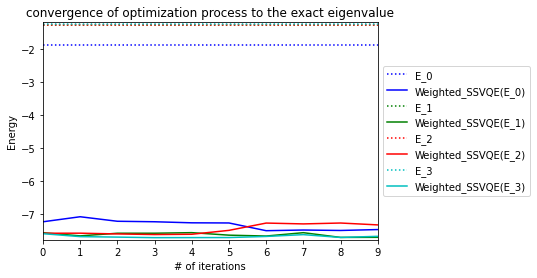

In [39]:
H2_approximated_energies = {'approximated_eneriges_0': [-7.231052657869664, -7.078319612689266, -7.215401871826676, -7.230221135636873, -7.262455020005291, -7.267031049860837, -7.501572363017872, -7.4813356803216, -7.4947234955867215, -7.467291869278843], 'approximated_eneriges_1': [-7.563886100199448, -7.658659320088765, -7.578874516640113, -7.5780818494863516, -7.560965458088562, -7.637089945397857, -7.663568893024004, -7.5617725937859115, -7.705323888763656, -7.702392677865555], 'approximated_eneriges_2': [-7.579265030661066, -7.5773451380441585, -7.599916344085796, -7.618297129617218, -7.60986111046384, -7.491511476610149, -7.270122634763994, -7.295684673991992, -7.268791877445621, -7.325654461172013], 'approximated_eneriges_3': [-7.592367719916387, -7.681333606694948, -7.696180773666084, -7.713150310751485, -7.710985775433959, -7.709751408629662, -7.676158468825629, -7.621108302975905, -7.706198964984833, -7.67241616951112]}
plot_convergence_of_optimization_process(H2_approximated_energies, H2_molecule_Hamiltonian_4_qubits, margin=0.01)

##  Transverse Ising Model 4 qubits

In [40]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [41]:
%%time
TI_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(transverse_ising_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.21s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.29s/it]


CPU times: total: 15min 22s
Wall time: 15min 42s


In [42]:
compare_exact_and_approximated_eigenvectors(transverse_ising_4_qubits, TI_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j)]

Approximated K Eigenvalues:
[1.3290864882981321, 1.499809612547787, 1.8655597729585458, 1.9227581244692806]

Mean Approximation error:
0.16282402812018626


In [43]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.490700593111317, -7.569308492554165, -7.438191844805709, -7.5867839345437424, -7.558493626890667, -7.4168428878734405, -7.638427855426193, -7.509673777059569, -7.554367078537331, -7.5798112461689175, -7.4763776257680945, -7.587119520618607, -7.592825860419122, -7.173527304372202, -7.4544549514346725, -7.555678140078989, -7.535576045814802, -7.569293067297772, -7.56767162957801, -7.660024094145796, -7.6534596083536455, -7.6960941658733715, -7.64841724078481, -7.707026267752197, -7.725043491750451, -7.736032243319994, -7.7252843912854585, -7.670864164020332, -7.729738251616463, -7.725558469104271, -7.732160342721239, -7.643999491391236, -7.754687811548367, -7.746540675348194, -7.702714707498153, -7.7090481935872175, -7.7468713351869365, -7.74518697130509, -7.7386397704422105, -7.741273567860519, -7.701120737697892, -7.740945064435749, -7.739231727095247, -7.750343376378801, -7.741793840123544, -7.747793926062887, -7.747395046530334, -7.740045706948089, -7.

[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j)]


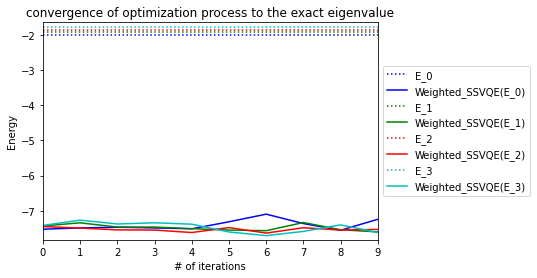

In [44]:
TI_approximated_energies = {'approximated_eneriges_0': [-7.527374926796388, -7.490948460217839, -7.471351892950928, -7.490702422799052, -7.515817970419744, -7.31595982882803, -7.099053535351137, -7.366127033312333, -7.558208686809385, -7.245080154006243], 'approximated_eneriges_1': [-7.435160167575143, -7.3454563436422955, -7.467036090723377, -7.46674892502807, -7.512177681355114, -7.551799781215262, -7.56977798445727, -7.337817913611366, -7.542405722352239, -7.604048469384494], 'approximated_eneriges_2': [-7.45094378726649, -7.494835406044515, -7.546427492721137, -7.5519911271001785, -7.621700741850081, -7.480593237888603, -7.63756007071119, -7.485733803067446, -7.551661441110606, -7.532503440725798], 'approximated_eneriges_3': [-7.420383731278358, -7.269163097081034, -7.378626010242662, -7.344163256333969, -7.384431167351, -7.606108205702219, -7.7098709634708, -7.590454974935595, -7.404154849273452, -7.621812392089753]}
plot_convergence_of_optimization_process(TI_approximated_energies, transverse_ising_4_qubits, )